In [2]:
import csv
from io import StringIO
from sqlalchemy import create_engine, text
import pandas as pd
import psycopg2

In [3]:
cnxn_string = ("postgresql+psycopg2://{username}:{pswd}@{host}:{port}/{database}")
engine = create_engine(
    cnxn_string.format(
        username="postgres",
        pswd="postgres",
        host="localhost",
        port="5432",
        database="sqlda"
    )
)

In [4]:
def psql_insert_copy(table, conn, keys, data_iter):
    # Pobiera połączenie DBAPI które udostępnia kursor
    dbapi_conn = conn.connection
    with dbapi_conn.cursor() as cur:
        s_buf = StringIO()
        writer = csv.writer(s_buf)
        writer.writerows(data_iter)
        s_buf.seek(0)
        columns = ', '.join('"{}"'.format(k) for k in keys)
        if table.schema:
            table_name = '{}.{}'.format(table.schema, table.name)
        else:
            table_name = table.name
        sql = 'COPY {} ({}) FROM STDIN WITH CSV' .format(table_name, columns)
        cur.copy_expert(sql, s_buf)

In [5]:
public_trans_data = pd.read_csv('E:\\public_transportation_statistics_by_zip_code.csv')
public_trans_data.head()

,zip_code,public_transportation_pct,public_transportation_population
0,1379,3.3,13
1,1440,0.4,34
2,1505,0.9,23
3,1524,0.5,20
4,1529,1.8,32


In [6]:
public_trans_data.to_sql(
    'public_trans_data',
    engine,
    if_exists='replace',
    index=False,
    method=psql_insert_copy
)

In [7]:
query_min_max_pct = """
SELECT 
    MIN(public_transportation_pct) AS min_pct,
    MAX(public_transportation_pct) AS max_pct
FROM 
    public_trans_data
WHERE
    public_transportation_pct IS NOT NULL
"""

min_max_pct = pd.read_sql_query(query_min_max_pct,engine)

In [8]:
min_max_pct = pd.read_sql_query(query_min_max_pct,engine)
print(min_max_pct)

       min_pct  max_pct
0 -666666666.0    100.0


In [11]:
query_avg_sales_amount_per_trans_pct = """
WITH customers_data as (
	SELECT 
	    *
	FROM 
	    public_trans_data p
	JOIN
		customers c
		ON p.zip_code = c.postal_code::bigint
	JOIN
		sales s
		ON c.customer_id = s.customer_id 	
)
SELECT
	AVG(cd.sales_amount) as avg_below_10_pct,
		(SELECT
		AVG(cd.sales_amount) as avg_above_10_pct
	FROM
		customers_data cd
	WHERE
		cd.public_transportation_pct <= 10)
FROM
	customers_data cd
WHERE
	cd.public_transportation_pct > 10
"""

avg_sales_amount_per_trans_pct = pd.read_sql_query(query_avg_sales_amount_per_trans_pct,engine)
print(avg_sales_amount_per_trans_pct)


   avg_below_10_pct  avg_above_10_pct
0       6501.975633       7261.727347


<Axes: >

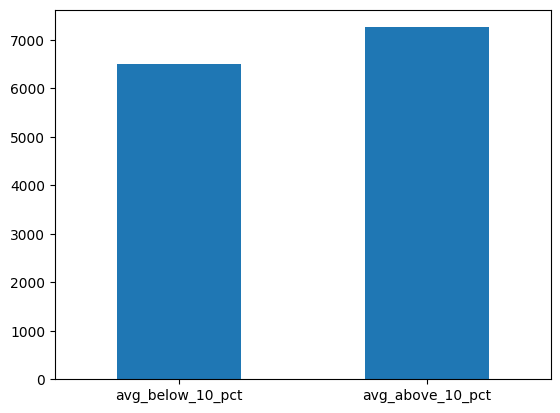

In [23]:
my_data = avg_sales_amount_per_trans_pct
my_data.T.plot(kind='bar', rot=0, legend=False)

In [29]:
%%time
my_data.to_sql(
    'my_data',
    engine,
    if_exists='replace',
    index=False,
    method=psql_insert_copy
)

CPU times: total: 0 ns
Wall time: 15.9 ms


In [30]:
%%time
my_data.to_sql(
    'my_data',
    engine,
    if_exists='replace',
    index=False
)

CPU times: total: 0 ns
Wall time: 54.2 ms


1

<Axes: ylabel='Frequency'>

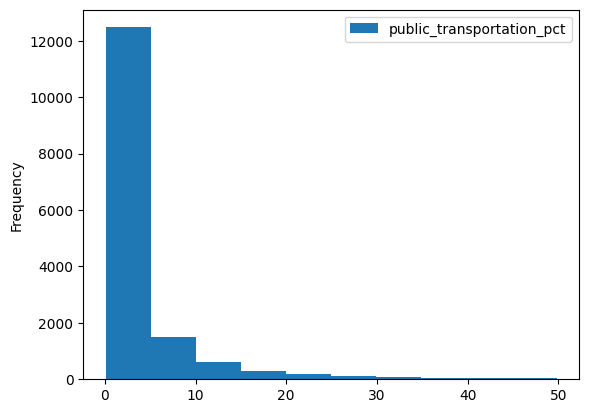

In [31]:
data = pd.read_sql_query(""" 
    SELECT 
        *
    FROM 
        public_transportation_by_zip 
    WHERE 
        public_transportation_pct > 0
    AND 
        public_transportation_pct < 50
""", engine) 
data.plot.hist(y='public_transportation_pct')

In [33]:
data = pd.read_sql_query(""" 
    SELECT
        10 * ROUND(public_transportation_pct/10) AS public_transport,
        COUNT(s.customer_id) * 1.0 / COUNT(DISTINCT c.customer_id) AS sales_per_customer
    FROM 
        customers c
    INNER JOIN 
        public_transportation_by_zip t 
        ON t.zip_code = c.postal_code
    LEFT JOIN 
        sales s 
        ON s.customer_id = c.customer_id 
    WHERE 
        public_transportation_pct >= 0
    GROUP BY 
        1
""", engine)

data.to_csv('E:\sales_vs_public_transport_pct.csv')

<>:19: SyntaxWarning: invalid escape sequence '\s'
<>:19: SyntaxWarning: invalid escape sequence '\s'
C:\Users\karol\AppData\Local\Temp\ipykernel_8988\3182900501.py:19: SyntaxWarning: invalid escape sequence '\s'
  data.to_csv('E:\sales_vs_public_transport_pct.csv')
